# Figure 3. b) analysis

This notebook replicates the per-function co-annotation evaluations from Fig. 3 b) and plots the resulting heatmap. This analyses is the same as Fig. 2 b), but instead compares across methods rather than input networks.

In [1]:
# ignore Pandas `FutureWarning` on `lookup` method
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json
import numpy as np
import pandas as pd
import networkx as nx
from functools import reduce
from itertools import product
from typing import Dict, List
from pathlib import Path
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity

import textwrap
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

First, import methods. Methods producing feature outputs are **deepNF**, **Mashup**, **multi-node2vec** and **BIONIC**. Methods producing network outputs are **Union** and **iCell**.

In [2]:
input_path = Path("../data/methods")

net_method_names = ["Union.txt", "iCell.txt"]
feat_method_names = ["deepNF.csv", "Mashup.csv", "multi-node2vec.csv", "yeast_BIONIC_features.csv"]

# import feature-based method results
features = {name.split(".")[0]: pd.read_csv(input_path / name, index_col=0) for name in feat_method_names}
features["BIONIC"] = features["yeast_BIONIC_features"]
features.pop("yeast_BIONIC_features")

# import nets
networks = {name.split(".")[0]: nx.read_weighted_edgelist(input_path / name) for name in net_method_names}

Consolidate genes across networks and features to ensure each dataset contains the same set of genes.

In [3]:
feature_genes = [list(feat.index) for feat in features.values()]
network_genes = [list(net.nodes()) for net in networks.values()]
consolidated_genes = reduce(np.union1d, network_genes + feature_genes)

def consolidate_features(
    features: Dict[str, pd.DataFrame], genes: List[str]
) -> Dict[str, pd.DataFrame]:
    """Consolidates features by ensuring they share the same genes in the same order."""

    consolidated = {}
    for name, feat in features.items():
        consolidated[name] = feat.reindex(genes).fillna(0)
    return consolidated

def consolidate_networks(networks: Dict[str, nx.Graph], genes: List[str]) -> Dict[str, nx.Graph]:
    """Consolidates networks by ensuring they share the same genes in the same order."""
    
    consolidated = {}
    for name, net in networks.items():
        new_net = nx.Graph()
        new_net.add_nodes_from(genes)

        # handle weighted and unweighted edges
        edges = [(edge[0], edge[1], 1.0) for edge in net.edges()] if len(list(net.edges())[0]) < 3 else net.edges()

        new_net.add_weighted_edges_from(edges)
        new_net = new_net.subgraph(genes)
        consolidated[name] = new_net
    return consolidated

features = consolidate_features(features, consolidated_genes)
networks = consolidate_networks(networks, consolidated_genes)

Import bioprocess standard. Reduce the standard and networks/features to only include genes common to both.

In [4]:
# import standard
input_path = Path("../data/standards")
with (input_path / "Costanzo-bioprocess.json").open("r") as f:
    standard = json.load(f)

# reduce standard
new_standard = {}
for module_name, members in standard.items():
    new_members = [gene for gene in members if gene in consolidated_genes]
    if len(new_members) > 1:  # only include modules with more than 1 member
        new_standard[module_name] = new_members
standard = new_standard

# reduce features and networks
standard_genes = reduce(np.union1d, list(standard.values()))
features = consolidate_features(features, standard_genes)
networks = consolidate_networks(networks, standard_genes)

Define functions to perform co-annotation evaluations on features and networks.

In [5]:
def compute_average_precision(dataset: pd.DataFrame, standard: pd.DataFrame) -> float:
    """Computes the average precision score for the given input `dataset` based on `standard`"""
    y_true = standard.iloc[:, 2].values
    # NOTE: `lookup` is depreciated for no good reason, I suspect it will be undepreciated
    # soon, see here: https://github.com/pandas-dev/pandas/issues/39171
    y_score = dataset.lookup(standard.iloc[:, 0], standard.iloc[:, 1])
    avp = average_precision_score(y_true, y_score)
    return avp

def evaluate_features(features: pd.DataFrame, standard: pd.DataFrame) -> float:
    """Function to handle co-annotation evaluation for feature-type inputs"""
    sim = cosine_similarity(features.values)
    features = pd.DataFrame(sim, index=features.index, columns=features.index).fillna(0)
    avp = compute_average_precision(features, standard)
    return avp

def evaluate_network(network: nx.Graph, standard: pd.DataFrame) -> float:
    # map network to DataFrame for pairwise lookup
    network = nx.to_pandas_adjacency(network)
    avp = compute_average_precision(network, standard)
    return avp


Perform the co-annotation evaluation for each module (bioprocess) in the standard.

In [6]:
standard_evaluations = {}

for function, genes in standard.items():

    # skip any bioprocesses that contain fewer than 20 genes
    if len(genes) < 20:
        continue

    print(f"{function}, Size: {len(genes)}")

    # get positive pairs
    positive_pairs = nx.complete_graph(genes)
    positive_pairs.add_nodes_from(standard_genes)
    positive_pairs.remove_edges_from(nx.selfloop_edges(positive_pairs))

    # get negative pairs
    negative_pairs = list(product(genes, set(standard_genes) - set(genes)))
    negative_net = nx.Graph()
    negative_net.add_nodes_from(standard_genes)
    negative_net.add_edges_from(negative_pairs)
    negative_net.remove_edges_from(nx.selfloop_edges(negative_net))
    negative_pairs = negative_net

    # create function-specific coannotation standard
    positive_pairs = nx.to_pandas_edgelist(positive_pairs)
    positive_pairs["score"] = 1
    negative_pairs = nx.to_pandas_edgelist(negative_pairs)
    negative_pairs["score"] = 0
    pairs = pd.concat([positive_pairs, negative_pairs])

    # evaluate feature sets and networks
    evaluations = {}
    for name, feat in features.items():
        avp_score = evaluate_features(feat, pairs)
        evaluations[name] = avp_score

    for name, net in networks.items():
        avp_score = evaluate_network(net, pairs)
        evaluations[name] = avp_score

    standard_evaluations[function] = evaluations

Cell polarity & morphogenesis, Size: 99
Glycosylation, protein folding/targeting, cell wall biosynthesis, Size: 156
Ribosome biogenesis, Size: 72
Protein degradation/turnover, Size: 57
Nuclear-cytoplasmic transport, Size: 38
MVB sorting and pH depending signaling, Size: 21
mRNA & tRNA processing, Size: 94
Peroxisome, Size: 22
DNA replication & repair, Size: 93
Vesicle traffic, Size: 93
Transcription & chromatin organization, Size: 105
Mitosis & chromosome segregation, Size: 192
rDNA & ncDNA processing, Size: 88
Respiration, oxidative phosphorylation, mitochondrial targeting, Size: 138


Compute average performance of networks/features across functional categories.

In [7]:
df = pd.DataFrame(standard_evaluations)
df.mean(axis=1)

deepNF            0.518612
Mashup            0.368557
multi-node2vec    0.235148
BIONIC            0.534543
Union             0.232426
iCell             0.160275
dtype: float64

Plot heatmap of results.

<Figure size 432x288 with 0 Axes>

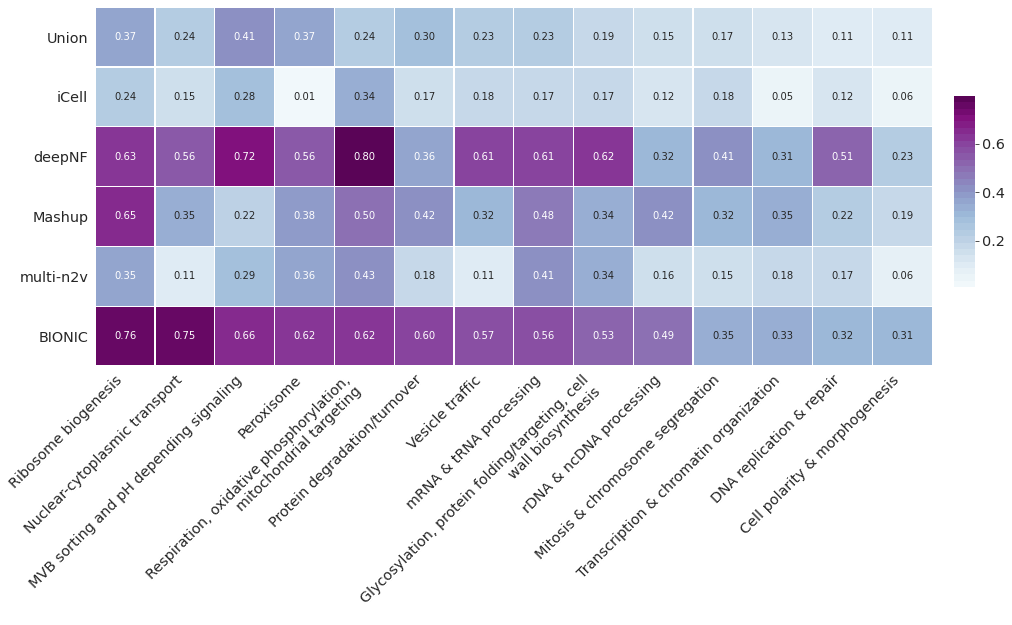

In [17]:
# increase label sizes
mpl.rcParams["axes.labelsize"] = "x-large"
mpl.rcParams["xtick.labelsize"] = "x-large"
mpl.rcParams["ytick.labelsize"] = "x-large"
mpl.rcParams["legend.fontsize"] = "x-large"

plt.clf()

sns.set({"figure.facecolor": "white"})

# create dataframe from `standard_evaluations`
df_data = []
for term, term_values in standard_evaluations.items():
    for input_label, average_precision in term_values.items():
        df_data.append([term, input_label, average_precision])
df = pd.DataFrame(df_data, columns=["Functional Category", "Method", "Average Precision"])

df = df.pivot("Functional Category", "Method", "Average Precision")
df.index = [textwrap.fill(idx, width=50) for idx in df.index]  # wrap bioprocess names so they fit in figure
df.sort_values(df.columns[0], inplace=True, ascending=False)  # sort bioprocesses by BIONIC performance
df = df[["Union", "iCell", "deepNF", "Mashup", "multi-node2vec", "BIONIC"]]  # reorder methods
df.columns = [name if name != "multi-node2vec" else "multi-n2v" for name in df.columns]  # shorten "multi-node2vec" name
df = df.T

fig, ax = plt.subplots(1, 1, figsize=(15, 9))
cbar_ax = fig.add_axes([0.92, 0.348, 0.02, 0.295])
sns.heatmap(
    df,
    linewidths=0.25,
    square=True,
    annot=True,
    cmap=sns.color_palette("BuPu", 30),
    cbar_ax=cbar_ax,
    cbar=True,
    fmt=".2f",
    ax=ax,
)
plt.tick_params(axis="y", left=False)
ax.set_yticklabels(ax.get_yticklabels())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.show()